# Tabular data exploration

In [14]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [15]:
df = pd.read_csv("/Users/charlesoneill/DataspellProjects/bushfireanalysis/input/bushfire_clean.csv")
df.drop(columns=['Unnamed: 0', 'Year', 'Year.1'], inplace=True)
cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.head()

,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt
0,56.9,67.8,280.3,71.6,244.9,62.6,75.0,41.0,89.4,31.4,54.0,42.0,784.1,727.2,659.4,0
1,239.9,52.5,74.4,517.2,172.2,133.4,158.2,62.8,100.3,270.1,4.1,69.7,1189.6,949.7,897.2,0
2,109.7,86.5,21.9,10.4,114.1,138.7,50.4,387.8,238.6,211.1,264.8,67.2,481.3,371.6,285.1,0
3,269.2,24.8,62.4,41.5,279.1,18.2,37.0,171.7,139.6,78.1,407.5,9.5,695.2,426.0,401.2,0
4,25.7,15.1,86.3,74.2,38.0,36.8,22.7,8.4,85.1,42.6,236.3,97.8,276.1,250.4,235.3,366000


In [16]:
dep_var = 'ha_burnt'

In [17]:
train_idx = [x for x in range(0, 45)]
valid_idx = [x for x in range(45, 60)]
splits = (list(train_idx), list(valid_idx))

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, cat, cont, y_names=dep_var, splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision tree

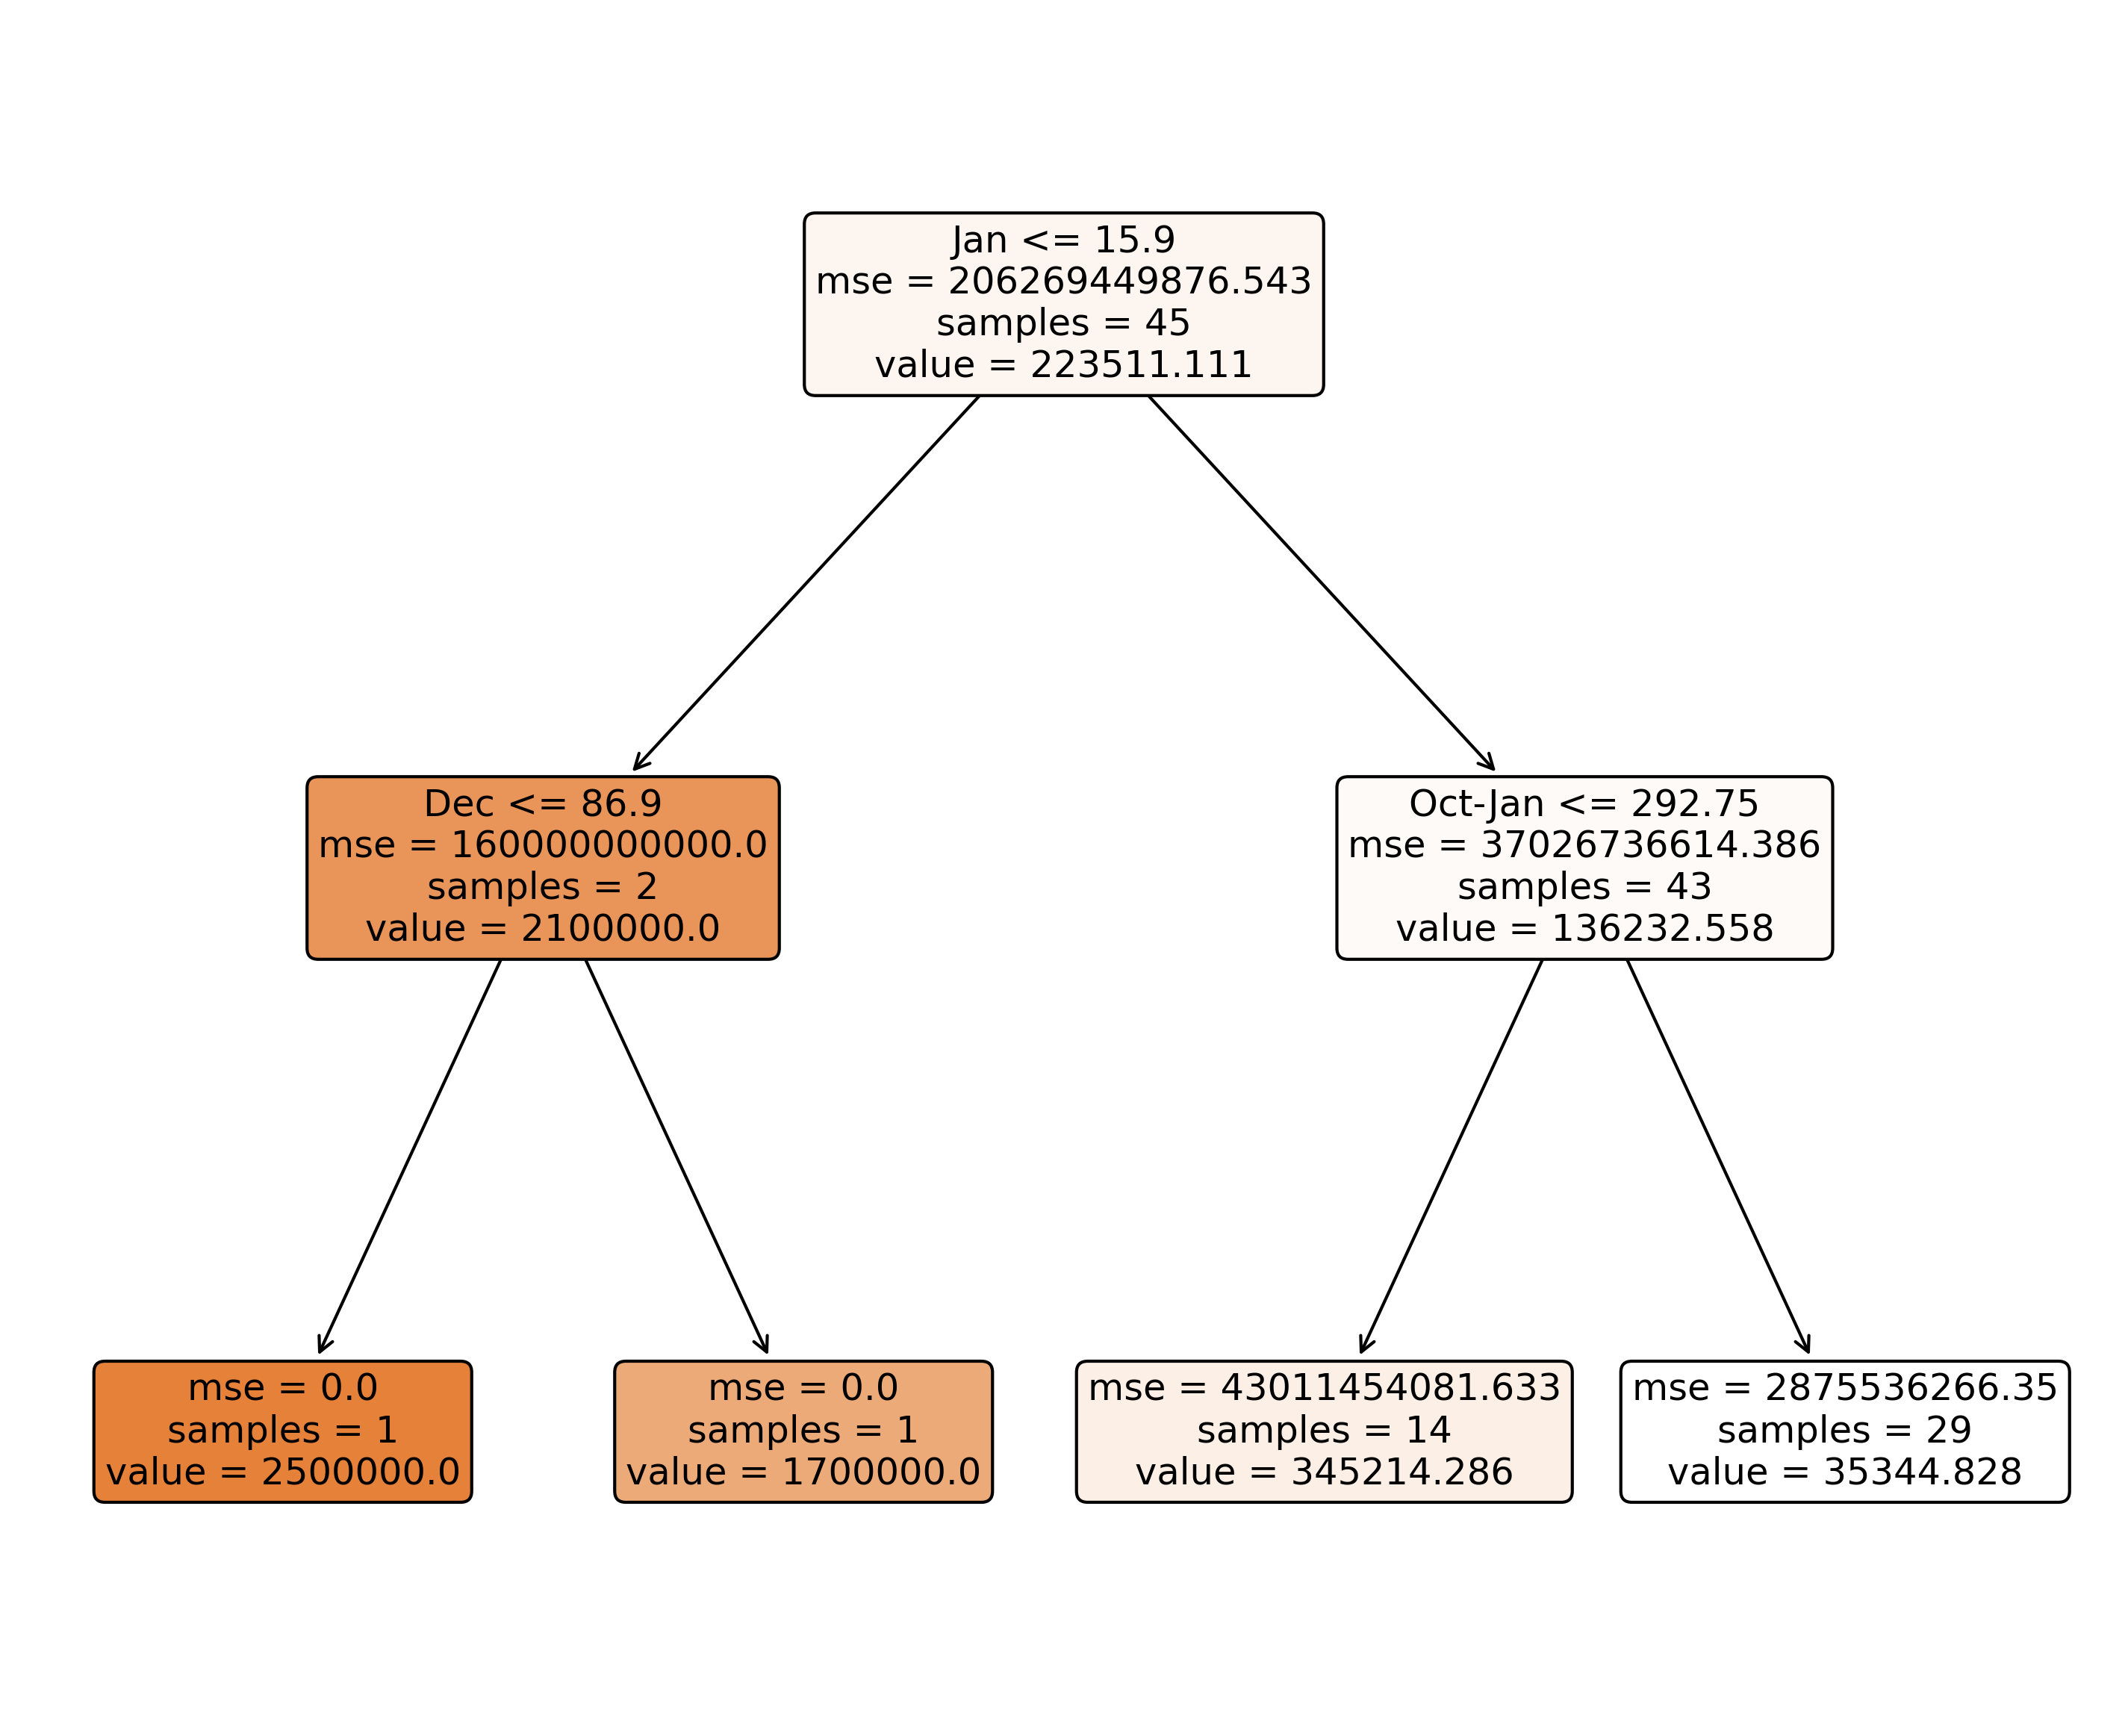

In [19]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
from sklearn import tree
fig = plt.figure(figsize=(12,10), dpi=300)
ax = fig.add_subplot()
tree.plot_tree(m, feature_names = cont, 
               class_names = dep_var,
              rounded=True,
              filled=True, ax = ax);
plt.savefig("decisiontree.png", dpi=300)

In [20]:
m = DecisionTreeRegressor()
m.fit(xs, y);
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [21]:
m_rmse(m, xs, y)

0.0

In [22]:
m_rmse(m, valid_xs, valid_y)

1474606.862862

In [23]:
m_rmse(m, valid_xs[:-1], valid_y[:-1])

193604.161703

In [24]:
m.get_n_leaves(), len(xs)

(31, 45)

## Random forest

In [25]:
def rf(xs, y, n_estimators=40, max_samples=45,
       max_features=3, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
m = rf(xs, y);

In [26]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(350678.078716, 1409557.129632)

In [27]:
m_rmse(m, xs, y), m_rmse(m, valid_xs[:-1], valid_y[:-1])

(350678.078716, 263427.739257)

In [28]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

1409557.129632

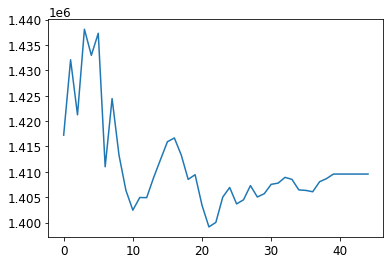

In [29]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(45)]);

In [30]:
r_mse(m.oob_prediction_, y)

444526.713397

### Tree variance for confidence prediction

In [31]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 15)

In [32]:
preds_std = preds.std(0)
preds_std[:5]

array([194567.89610359, 264075.19643429, 225712.06053551, 340512.55239885, 362125.96298701])

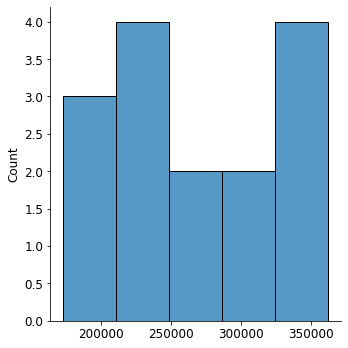

In [33]:
import seaborn as sns
sns.displot(preds_std);

### Feature importance

In [34]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
5,Jan,0.159149
13,Sep-Jan,0.141276
8,Apr,0.138237
14,Oct-Jan,0.115451
0,Aug,0.109791
12,Aug-Jan,0.068647
1,Sep,0.063789
2,Oct,0.059899
9,May,0.046128
4,Dec,0.033119


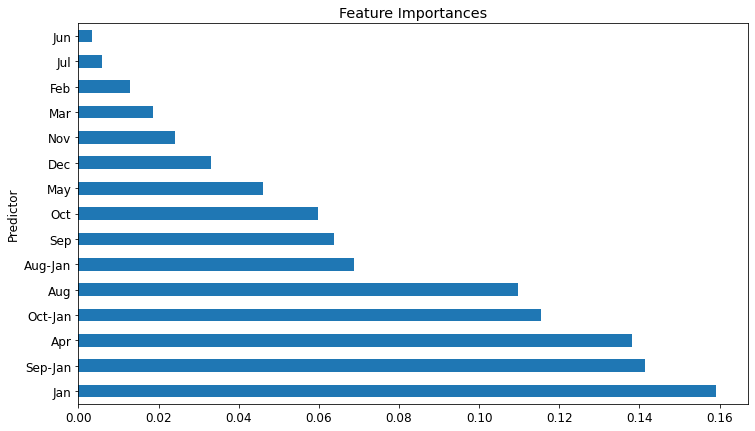

In [35]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', 
                   figsize=(12,7), xlabel = 'Predictor',
                   title = 'Feature Importances',
                   legend=False)

plot_fi(fi[:30]);

### Removing redundant features

In [36]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

14

In [37]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(368332.915151, 1398660.943977)

In [38]:
len(xs.columns), len(xs_imp.columns)

(15, 14)

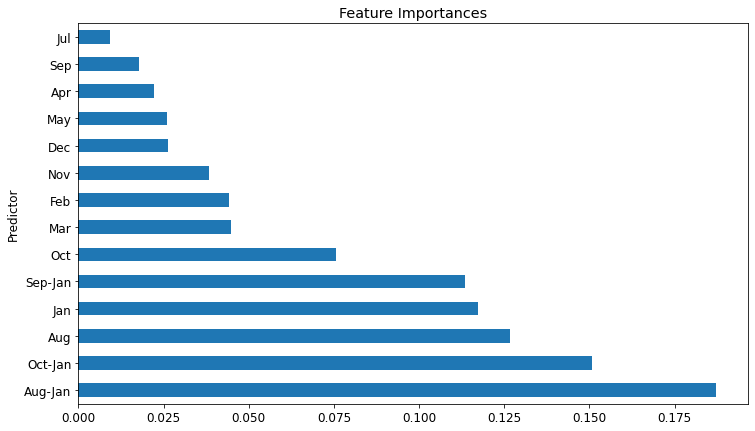

In [39]:
plot_fi(rf_feat_importance(m, xs_imp));

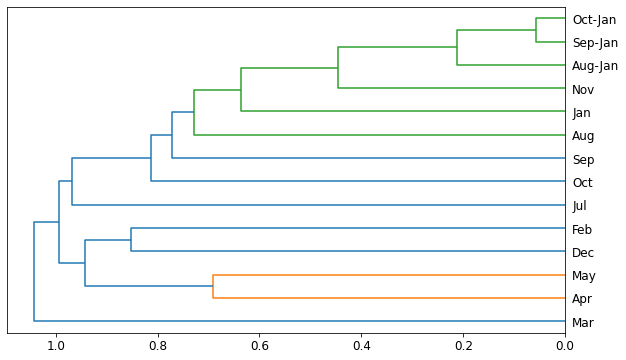

In [40]:
cluster_columns(xs_imp)

In [41]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=45, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_
get_oob(xs_imp)

-0.05202111626269956

In [42]:
to_drop = ['Sep-Jan', 'Oct-Jan', 'Dec', 'Apr']
get_oob(xs_imp.drop(to_drop, axis=1))

-0.02339402532265944

In [43]:
to_drop = []
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(371768.218587, 1396530.873288)

### Partial dependence

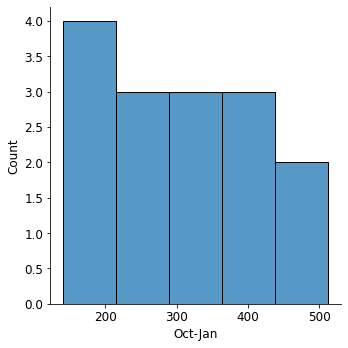

In [44]:
sns.displot(valid_xs_final['Oct-Jan']);

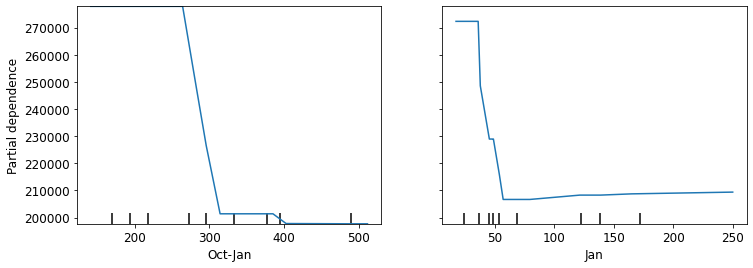

In [45]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['Oct-Jan','Jan'],
                        grid_resolution=20, ax=ax);

### Tree interpretation

In [46]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

(array([281404.44447505]), 221482.7777777778, 59921.666697273315)

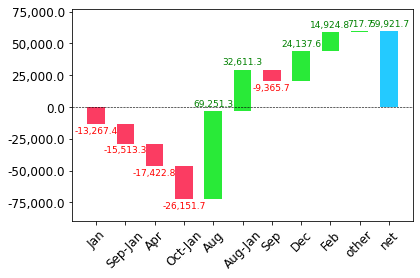

In [47]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45);

## Neural networ